In [1]:
# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# NumPy библиотека
import numpy as np
print(tf.__version__) 

Using TensorFlow backend.


2.2.0-dev20200314


Загрузим и посмотрим на данные

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000) 

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels))) 

Training entries: 25000, labels: 25000


In [4]:
print(train_data[0]) 

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
 len(train_data[0]), len(train_data[1]) 

(218, 189)

Загрузим словарь

In [6]:
# Индексы словаря связи слов и соотвествующих им чисел
word_index = imdb.get_word_index()

# Первые индексы зарезервированы
word_index = {k:(v+3) for k,v in word_index.items()}
word_index[""] = 0


reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text]) 

In [7]:
len(word_index)                # количество слов в словаре для описания

88585

In [8]:
decode_review(train_data[0]) 

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

Как мы видим разные отзывы к фильмам имеют разное количество слов.

In [9]:
len(train_data[0]), len(train_data[1]), len(train_data[3])

(218, 189, 550)

In [10]:
max(map(len, train_data))   # максимальная длина описания

2494

Для того чтобы выровнять размер входов - приведем их к одной длине max_len путем добавления 0 до необходимого размера

In [11]:
max_len = 256

In [12]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data, value=word_index[""], padding='post', maxlen=max_len)

test_data = keras.preprocessing.sequence.pad_sequences(test_data, value=word_index[""], padding='post', maxlen=max_len) 

In [13]:
 len(train_data[0]), len(train_data[1]) 

(256, 256)

In [14]:
 print(train_data[0]) 

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [15]:
def plotting_binary(history_dict):    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
    if 'binary_crossentropy' in history_dict.keys():    
        binary_crossentropy = history_dict['binary_crossentropy']
        val_binary_crossentropy = history_dict['val_binary_crossentropy']

        plt.plot(epochs, binary_crossentropy, label='binary_crossentropy')
        plt.plot(epochs, val_binary_crossentropy, label='val_binary_crossentropy')
        plt.title('Training and validation binary_crossentropy')
        plt.xlabel('Epochs')
        plt.ylabel('binary_crossentropy')
        plt.legend()

        plt.show()

### Создадим конструктор модели

In [16]:
def modelling(units=16, 
              vocab_size = 10000,  
              activation='relu', 
              dropout_rate=0.0,
              regularization=0, 
              normalization = 0
             ):

    vocab_size = len(word_index)

    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, 16))
    model.add(keras.layers.GlobalAveragePooling1D())
    if normalization:
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(units, activation=activation,
                                  kernel_regularizer=keras.regularizers.l2(regularization)))
    model.add(keras.layers.Dropout(dropout_rate)) 
    # model_1.add(keras.layers.Dense(256, activation='softmax'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

#     model.summary() 
    
    model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy', 'binary_crossentropy']
    )
    
    return model

## Начнем эксперименты

In [17]:
history_all = []

### Базовая модель

In [18]:
model = modelling()

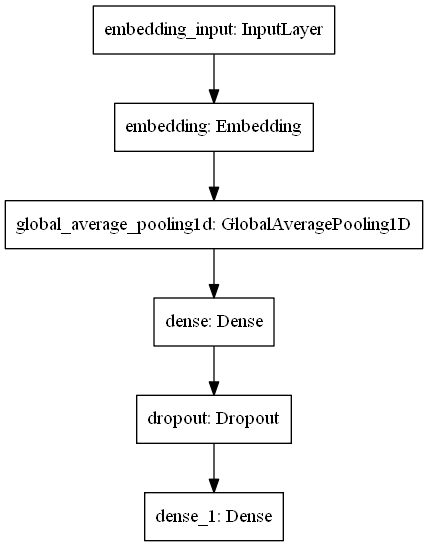

In [19]:
plot_model(model)

In [20]:
history = model.fit(train_data,
                    train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_data=(test_data, test_labels),
                    verbose=0)

782/782 [==============================] - 1s 692us/step - loss: 0.3929 - accuracy: 0.8677 - binary_crossentropy: 0.3928
[0.3928603529930115, 0.867680013179779, 0.39276331663131714]


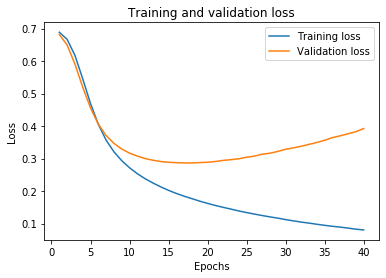

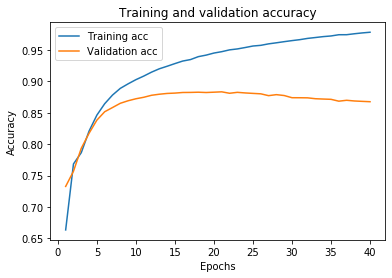

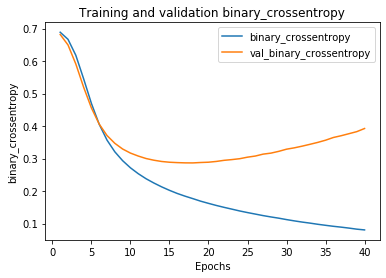

In [21]:
results = model.evaluate(test_data, test_labels)

print(results)
history_all.append(history)
plotting_binary(history.history)

### Попробуем увеличить количество нейронов

In [22]:
model_1 = modelling(units=256)

In [23]:
history_1 = model_1.fit(train_data,
                    train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_data=(test_data, test_labels),
                    verbose=0)

782/782 [==============================] - 1s 703us/step - loss: 0.7389 - accuracy: 0.8445 - binary_crossentropy: 0.7384
[0.738879919052124, 0.8444799780845642, 0.7383989095687866]


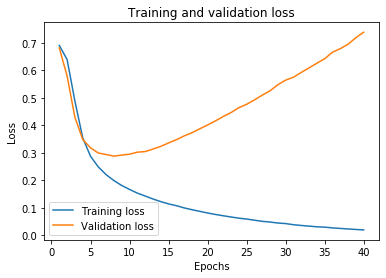

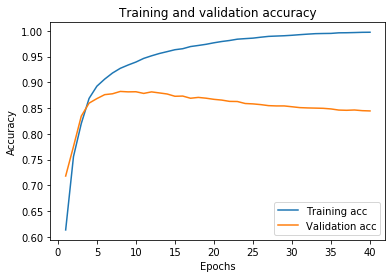

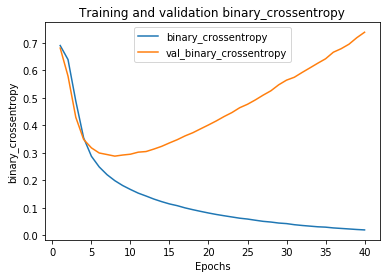

In [24]:
results_1 = model_1.evaluate(test_data, test_labels)

print(results_1)
history_all.append(history_1)
plotting_binary(history_1.history)

Как мы можем заметить происходит явное переобучение после 5-й эпохи.

Попробуем изменить используемое количество слов в словаре

In [25]:
model_2 = modelling(vocab_size=len(word_index))

In [26]:
history_2 = model_2.fit(train_data,
                    train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_data=(test_data, test_labels),
                    verbose=0)

782/782 [==============================] - 1s 932us/step - loss: 0.3905 - accuracy: 0.8678 - binary_crossentropy: 0.3904
[0.3904917240142822, 0.8677600026130676, 0.3903684914112091]


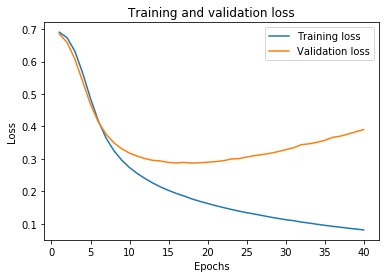

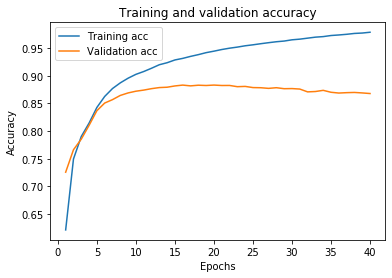

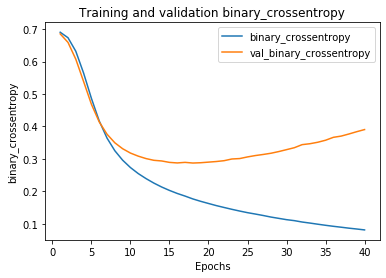

In [27]:
results_2 = model_2.evaluate(test_data, test_labels)

print(results_2)
history_all.append(history_2)

plotting_binary(history_2.history)

Результат немного улучшился.

Попробуем использовать регуляризацию

In [28]:
model_3 = modelling(vocab_size=len(word_index), regularization=0.01)

In [29]:
history_3 = model_3.fit(train_data,
                    train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_data=(test_data, test_labels),
                    verbose=0)

782/782 [==============================] - 1s 869us/step - loss: 0.3405 - accuracy: 0.8826 - binary_crossentropy: 0.2915
[0.3404773473739624, 0.88264000415802, 0.29151451587677]


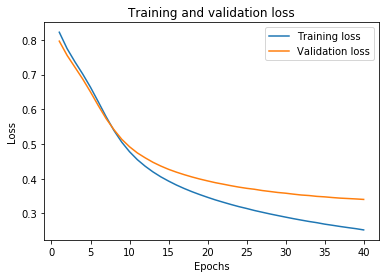

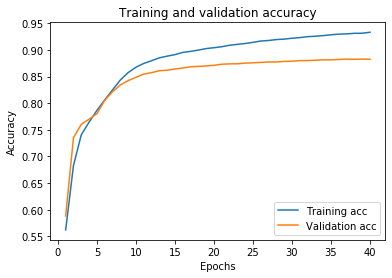

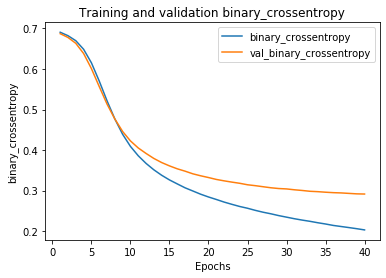

In [30]:
results_3 = model_3.evaluate(test_data, test_labels)

print(results_3)
history_all.append(history_3)

plotting_binary(history_3.history)

Результат улучшился. 

Теперь попробуем применить дропаут

In [31]:
model_4 = modelling(vocab_size=len(word_index), dropout_rate=0.8)

In [32]:
history_4 = model_4.fit(train_data,
                    train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_data=(test_data, test_labels),
                    verbose=0)

782/782 [==============================] - 1s 650us/step - loss: 0.3442 - accuracy: 0.8718 - binary_crossentropy: 0.3441
[0.344192236661911, 0.8717600107192993, 0.3441317081451416]


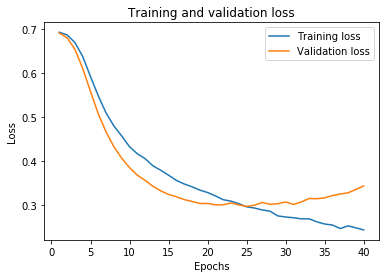

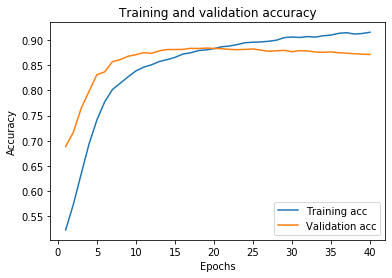

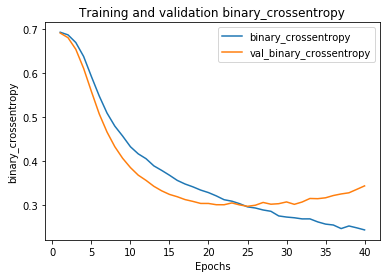

In [33]:
results_4 = model_4.evaluate(test_data, test_labels)

print(results_4)
history_all.append(history_4)

plotting_binary(history_4.history)

Оверфитинг уже не такой большой. Попробуем совместно применить регуляризацию и дропаут.

In [34]:
model_5 = modelling(vocab_size=len(word_index), dropout_rate=0.6, regularization=0.01)

In [35]:
history_5 = model_5.fit(train_data,
                    train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_data=(test_data, test_labels),
                    verbose=0)

782/782 [==============================] - 1s 720us/step - loss: 0.3509 - accuracy: 0.8833 - binary_crossentropy: 0.3029
[0.35090208053588867, 0.8833199739456177, 0.30291810631752014]


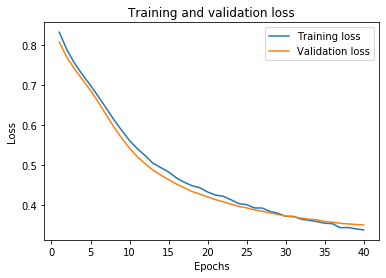

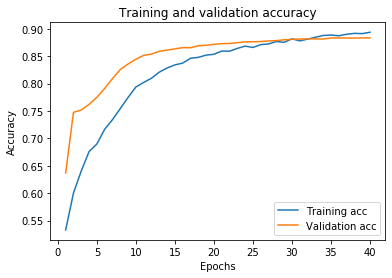

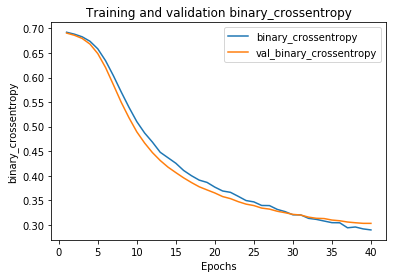

In [36]:
results_5 = model_5.evaluate(test_data, test_labels)

print(results_5)
history_all.append(history_5)

plotting_binary(history_5.history)

Уже явно получше.

Попробуем изменить функцию активации

In [37]:
model_6 = modelling(vocab_size=len(word_index), dropout_rate=0.6, regularization=0.01, activation='softmax')

In [38]:
history_6 = model_6.fit(train_data,
                    train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_data=(test_data, test_labels),
                    verbose=0)

782/782 [==============================] - 1s 642us/step - loss: 0.6931 - accuracy: 0.5000 - binary_crossentropy: 0.6931
[0.6931387782096863, 0.5, 0.6931259632110596]


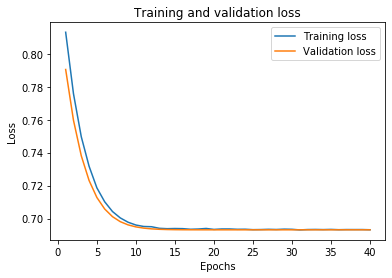

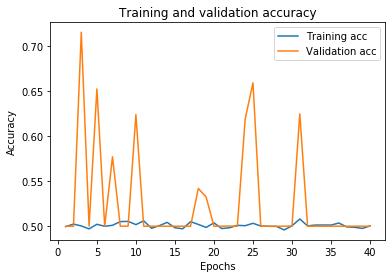

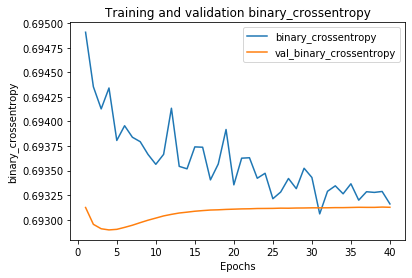

In [39]:
results_6 = model_6.evaluate(test_data, test_labels)

print(results_6)
history_all.append(history_6)

plotting_binary(history_6.history)

Выдает что попало.

Теперь попробуем применить нормализацию

In [40]:
model_7 = modelling(vocab_size=len(word_index), normalization=True, dropout_rate=0.5)

In [41]:
history_7 = model_7.fit(train_data,
                    train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_data=(test_data, test_labels),
                    verbose=0)

782/782 [==============================] - 1s 655us/step - loss: 1.3838 - accuracy: 0.8375 - binary_crossentropy: 1.3842
[1.3838361501693726, 0.8375200033187866, 1.3841919898986816]


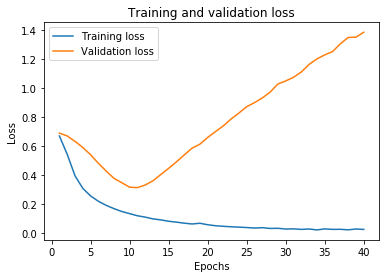

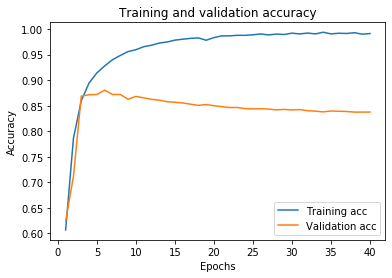

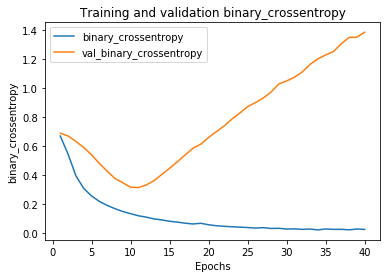

In [42]:
results_7 = model_7.evaluate(test_data, test_labels)

print(results_7)
history_all.append(history_7)

plotting_binary(history_7.history)

Явно совсем не туда

In [43]:
history_7.history.keys()

dict_keys(['loss', 'accuracy', 'binary_crossentropy', 'val_loss', 'val_accuracy', 'val_binary_crossentropy'])

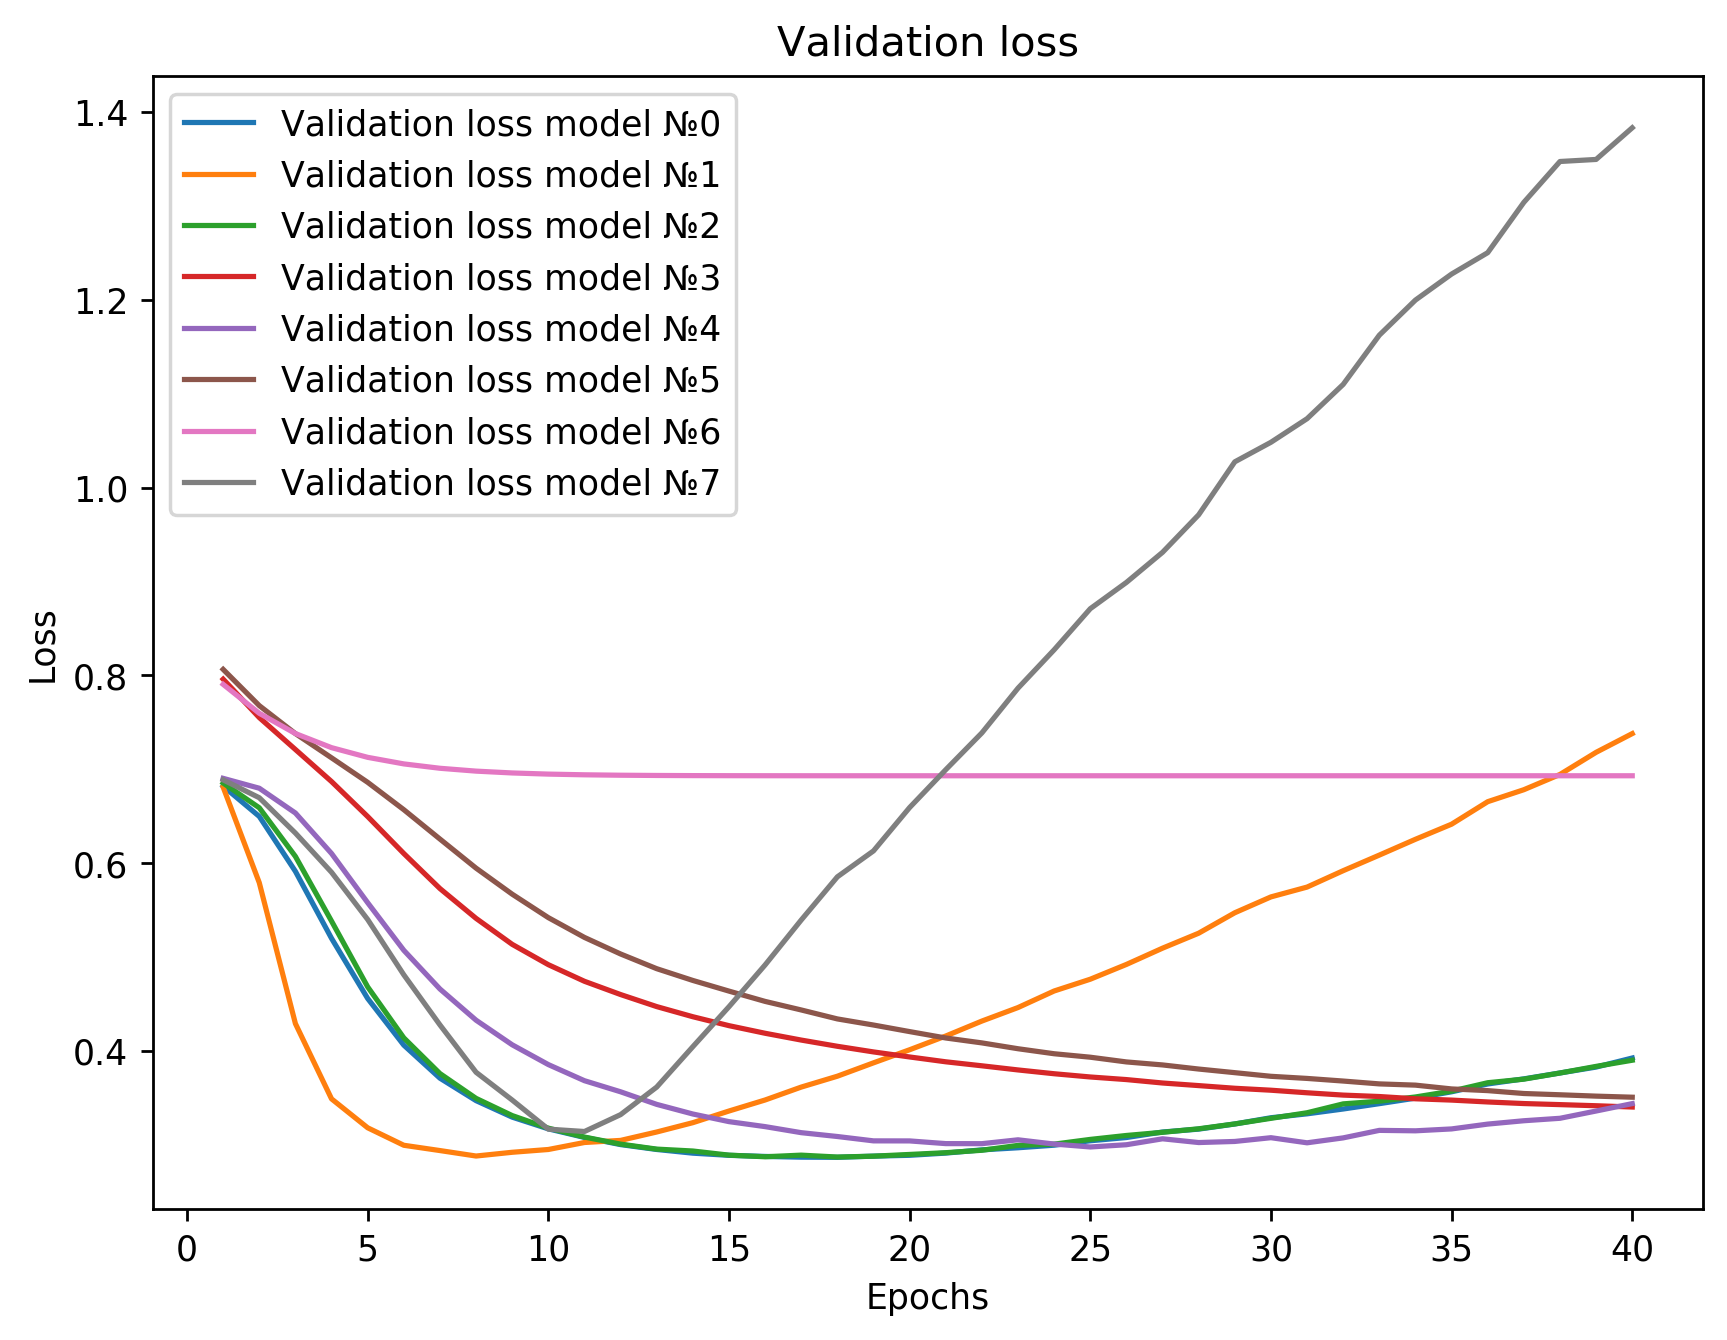

In [44]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=250, facecolor='w', edgecolor='k')
count = 0    
for i in history_all:
    acc = i.history['accuracy']
    val_acc = i.history['val_accuracy']
    loss = i.history['loss']
    val_loss = i.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, val_loss, label='Validation loss model №'+str(count))
    plt.title('Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    count += 1

Таким образом самой удачной оказались модели №3,4,5

Хотя мне кажется если увеличить количество эпох, то лучшей будет все же модель №5